# Dereverb - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: , MATR: 953546 )

Import libraries:

In [387]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
import scipy
from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import soundfile as sf
from numba import jit, cuda, vectorize

### Part 1: RIR and reverberation
From the image we can see that values of beta should be chosen between 0.2 for small rooms (4 m per side) and 1.8 for very big rooms (30 m per side);

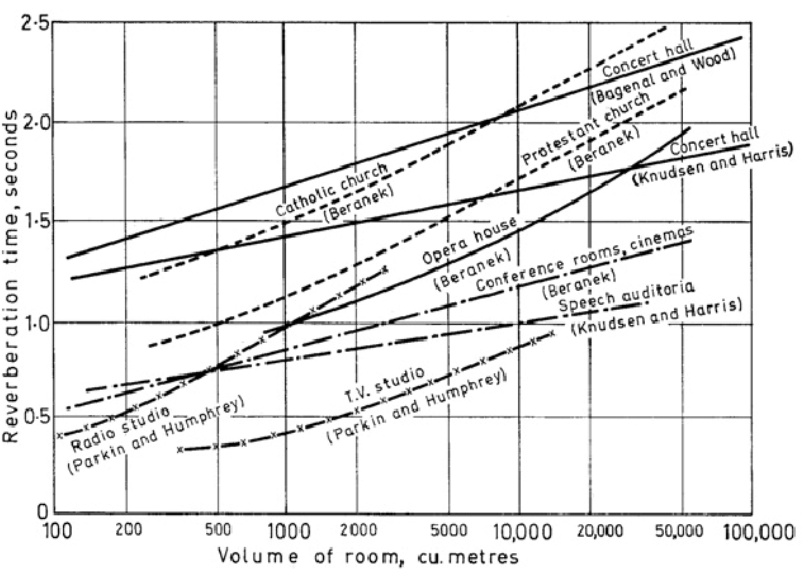

In [388]:
ipd.Image(filename = "images/RevTime1.png", width = 600, height = 300)

Let's define some parameters:

In [389]:
fs = 10000 # sampling rate (Hz)

rt60_tgt = 1  # reverberation time (s)
room_dim = [10, 7.5, 3.5]  # room dimensions (m)

source_pos = [5, 1, 1] # x, y, z position of the source (m)
mic_locs = np.c_[ [4.7, 5, 1.2] ] # location of the microphone / microphone array (m)

Visualization of the room with source and mics:

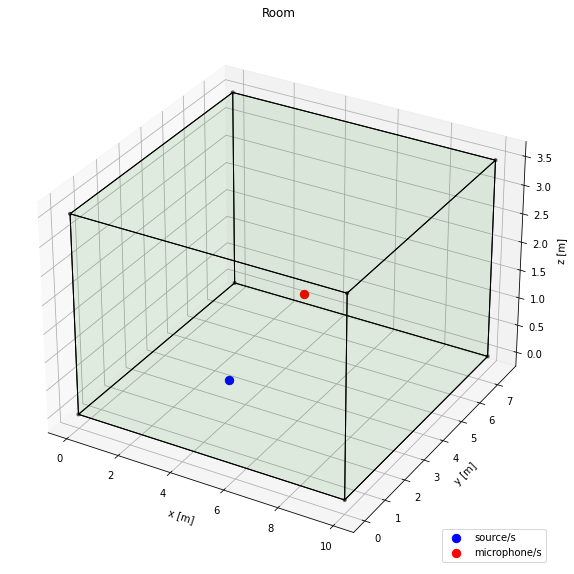

In [390]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70)
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70)

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

Now generate the RIR and apply it to the audio files

In [391]:
# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
audio, fs = librosa.load('audio/OSR_us_000_0010_8k.wav', sr=fs)
#audio = audio[:fs*2]

In [392]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

The volume of the room is 262.5 m³


In [393]:
# place the source in the room
room.add_source(source_pos, signal=audio); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [394]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
room.mic_array.to_wav(
    f"audio/generated/voiced_aREV.wav",
    norm=True,
    bitdepth=np.int16,
)

global_delay = pra.constants.get("frac_delay_length") // 2

print('Global delay introduced by the simulation:', global_delay)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[0, 0]))

Global delay introduced by the simulation: 40
The desired RT60 was 1 s
The measured RT60 is 1.6945 s


Original signal: (336232,)
RIR: (1, 1, 31577)
Reverberated signal: (367808,)


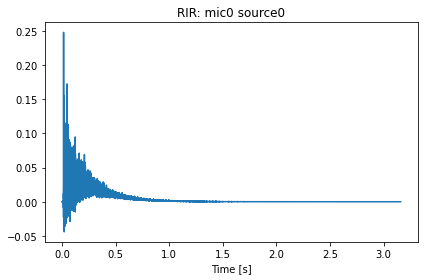

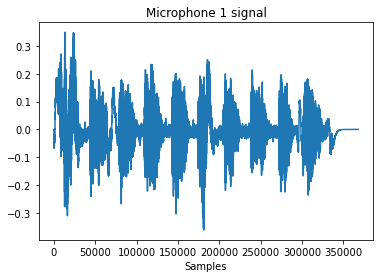

In [395]:
# Plot the RIRs
room.plot_rir()

plt.figure()
# plot signal at microphone 1
plt.plot(room.mic_array.signals[0, :])
plt.title("Microphone 1 signal")
plt.xlabel("Samples");


print('Original signal:', audio.shape)
print('RIR:', np.array(room.rir).shape )
print('Reverberated signal:', np.array(room.mic_array.signals[0, :]).shape)

In [396]:
# save RIR into a wav
# sf.write('audio/RIR.wav', np.array(np.squeeze(room.rir)), samplerate=fs)

#### Audio files
Dry signal:

In [397]:
ipd.display(ipd.Audio(audio, rate=fs))

Reverberated signal:

In [398]:
ipd.display(ipd.Audio(room.mic_array.signals[0, :], rate=fs))

In [399]:
# select a large number so that signals are all the same length:
sig_length = len(room.mic_array.signals[0, :])
N_samples = int(pow(2, np.ceil(np.log(sig_length)/np.log(2))))
N = N_samples
print(sig_length)
print('Next power of 2:', N_samples)

367808
Next power of 2: 524288


In [400]:
# step 1
#h = np.squeeze(np.asarray(room.rir))
h = np.squeeze(np.array(room.rir))
H = np.fft.fft(h, n=N)

print('RIR shape:', h.shape)
print('RIR DFT shape:', H.shape)

RIR shape: (31577,)
RIR DFT shape: (524288,)


In [401]:
# is DFT correct? yes. prove...
# freqaxis=np.fft.fftfreq(len(h[0,:]))
# print(np.squeeze(H).shape)
# mag = np.abs(np.squeeze(H))**2
# print(mag.shape)
# phase = np.angle(np.squeeze(H))
# print(mag.shape)
# print(freqaxis.shape)

# plt.figure(figsize=(5,10))
# plt.subplot(2,1,1)
# plt.plot(mag)
# plt.subplot(2,1,2)
# plt.plot(freqaxis,phase[0,:])

# inversecheck=np.fft.ifft(H_f[0,:])
# plt.figure(figsize=(5,10))
# plt.plot(inversecheck)

# ipd.display(ipd.Audio(inversecheck, rate=fs))
# ipd.display(ipd.Audio(room.rir[1][0], rate=fs))

In [402]:
# #compute the log of the frequency response
# H_hat=np.log(np.abs(H))+ 1j*np.angle(H)
# #compute the even part of the cepstrum
# n=np.arange(0,len(H[0,:]),1)
# k=n
# print(k.shape,n)
# #SOMMATORIA PROBLEMATICA, NP.SUM(NP.FROMITER(FUNZIONE PER N IN N, TIPO FINALE))
# #he=(1/len(H_f[0]))*np.sum(np.fromiter([(1/len(H_f[0])*np.log(np.abs(H_f))*np.exp((1j)*2*np.pi*k*n)) for n in n], H_f.dtype))

# #print(he.shape)

[     0      1      2 ... 524285 524286 524287]
(524288,)


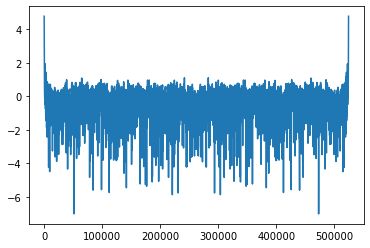

In [403]:
# step 2
# H_hat
H_amp_log = np.log(np.abs(H))
H_phase = np.angle(H)
H_hat = H_amp_log + H_phase

K = H.shape[-1]
n = np.arange(0,N)
print(n)
plt.plot(H_amp_log);
print(H_amp_log.shape)

In [404]:
# step 3
# INFERNALE (1 minuto e mezzo a 8kHz, 5 minuti a 16kHz)
# TODO: sistema per più microfoni

# h_e_hat = np.zeros((N,1), dtype=np.complex)

# for k in tqdm(range(K)): 
#     h_e_hat[k] = np.sum(H_amp_log[n]*np.exp(1j*(2*np.pi/N)*k*n))

# h_e_hat = (1/N)*h_e_hat

h_e_hat = np.fft.ifft(H_amp_log)

In [405]:
# INFERNALE
#h_e_hat = (1/N)*np.sum(s,axis=0) # sum all the elements in a column
#print('Size of matrix:', s.shape)
print('Size of even part of complex cepstrum:', h_e_hat.shape)

Size of even part of complex cepstrum: (524288,)


In [406]:
# reset s

In [407]:
# step 4
h_e_hat = np.squeeze(h_e_hat)

h_mp_hat = np.zeros(N, dtype=np.complex)

h_mp_hat[1:int(N/2)] = h_e_hat[1:int(N/2)]
h_mp_hat[0] =  h_e_hat[0]
h_mp_hat[int(N/2)] =  h_e_hat[int(N/2)]

C:\Users\Federico\miniconda3\envs\SASP\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


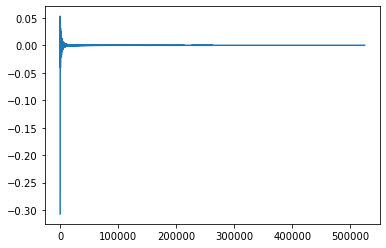

In [408]:
plt.plot(h_mp_hat)

In [409]:
print(h_mp_hat.shape)
print(n)

(524288,)
[     0      1      2 ... 524285 524286 524287]


In [410]:
# step 5
# INFERNALE
#s1 = np.zeros((N,N), dtype=np.complex)

#for i in tqdm(range(N)):
    #s1[i,:] = h_mp_hat[i]*np.exp(-1j*(2*np.pi/N)*k*i)

# ! CONTROLLA SOMMATORIA INDICE
    
# H_mp_hat = np.zeros((N,1), dtype=np.complex)

# for i in tqdm(range(K)): 
#     H_mp_hat[i] = np.sum(h_mp_hat[n]*np.exp(-1j*(2*np.pi/N)*i*n))
    
H_mp_hat = np.fft.fft(h_mp_hat, n=N)
    

In [411]:
#print(s1)

In [412]:
# INFERNALE
#H_mp_hat = np.sum(s1,axis=0) # sum all the elements in a column
print(H_mp_hat)

[2.23829037-3.31199961e-16j 2.23805614-1.82486704e-02j
 2.23737463-3.64728369e-02j ... 2.23622871+5.46482013e-02j
 2.23737463+3.64728369e-02j 2.23805614+1.82486704e-02j]


In [413]:
#reset s1

C:\Users\Federico\miniconda3\envs\SASP\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


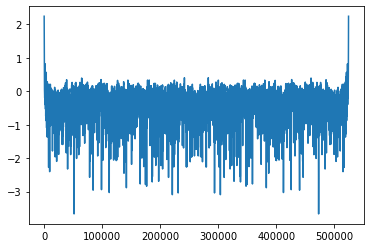

In [414]:
# debug
plt.plot(H_mp_hat)

(524288,)
(-0.13636164966725223-0.82205001023638j)


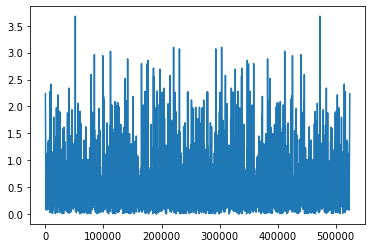

In [415]:
# step 6
H_mp = np.exp(H_mp_hat)
H_mp = np.squeeze(H_mp_hat)

#debug
print(H_mp.shape)
print(H_mp[2460])
plt.plot(np.abs(H_mp))

In [416]:
G_mp = 1/H_mp
G_mp = np.squeeze(G_mp)

#debug
print(G_mp.shape)

(524288,)


(524288,)


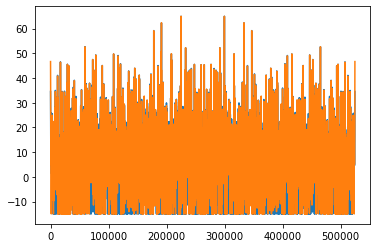

In [417]:
# modo 1 di calcolare H_ap
H_ap = H*G_mp
print(H_ap.shape)
plt.plot(librosa.amplitude_to_db(np.abs(H_ap)))
#plt.plot(np.angle(H_ap))

# modo 2 di calcolare H_ap
g_mp = np.fft.ifft(G_mp)
h_ap = np.convolve(h,g_mp)
H_ap1 = np.fft.fft(h_ap, n=N)
plt.plot(librosa.amplitude_to_db(np.abs(H_ap1)))
#plt.plot(np.angle(H_ap1))

# perchè all pass esce così?

Apply to signal and see the result:

(524288,)


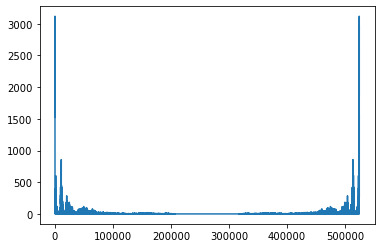

In [418]:
# wet DFT:
X = np.fft.fft(room.mic_array.signals[0, 0:N], n=N)
print(X.shape)
plt.plot(np.abs(X))

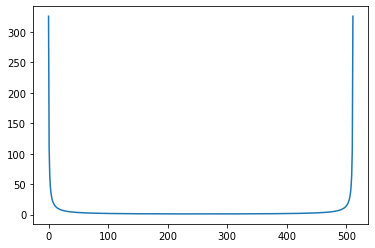

In [419]:
# esempio trovato di allpass
b = [0, 1]
a = [1, 0]
w, h = scipy.signal.freqz(b, a)
plt.plot(np.abs(np.fft.fft(h)))

(524288,)
[-182257.62996567-3.23117427e-27j  212904.95290203+6.49397300e+04j
  111239.19528711+4.57135052e+04j ...  104267.32597315+6.11335176e+04j
  111239.19528711-4.57135052e+04j  212904.95290202-6.49397300e+04j]


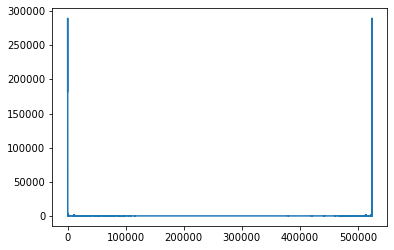

In [420]:
# dereverberated mult in freq:
X_der = X * H_mp * H_ap

#debug
print(X_der.shape)
print(X_der)
plt.plot(np.abs(X_der))

(1025, 719)


C:\Users\Federico\miniconda3\envs\SASP\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Federico\miniconda3\envs\SASP\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Federico\miniconda3\envs\SASP\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


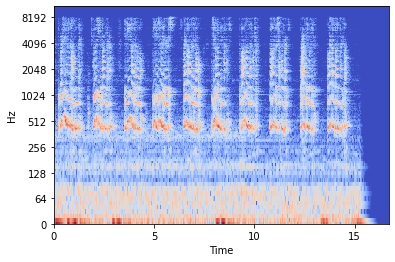

In [421]:
Y = librosa.stft(room.mic_array.signals[0, 0:N])
print(Y.shape)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y)),y_axis='log', x_axis='time', ax=ax)

In [422]:
x_der = np.fft.ifft(X_der)
x_der = np.abs(x_der)
print(x_der.shape)

(524288,)


In [423]:
ipd.display(ipd.Audio(x_der, rate=fs))

In [424]:
sf.write('audio/try.wav', x_der, samplerate=fs)

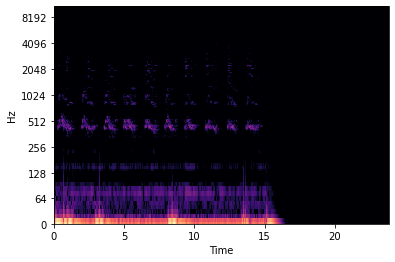

In [425]:
Y1 = librosa.stft(x_der)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y1)),y_axis='log', x_axis='time', ax=ax)